Подключаем модули:

In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from imutils import paths
import numpy as np
import pickle
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt

Это можно переносить в отдельный файл-конфиг:

In [2]:
# пути к используемым директориям
BASE_PATH = "./.."
IMAGES_PATH = "./.."
ANNOTS_PATH = "./.."
BASE_OUTPUT = "./.."
# пути к файлам
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "prop_two_classes.txt"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
# можно включить в файл-конфиг, но работать не будет.
# забиваем в моделе вручную. причину ещё не выяснил
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [5]:
# создаём пустые списки для заполнения картинками и их аргументами
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


Скрипт собирает всю имеющуюся информацию о картинках, которая пригодится до конца выполнения задания, в том числе и в оформлении. **Запускается один раз, для каждого датасета.** Принимает последовательность подходящую для формирования всех векторов.

In [ ]:
####### RUN ONLY ONCE #######


# возвращает данные в виде строки для записи в файл
def listToString(some_list): 
  str1 = "" 
  for ele in some_list: 
      str1 = str1 + ele + ","
  return str1.strip(",") 


# собирает данные для записи в файл
def get_area(name):
  result = [name + ".jpg"]
  with open(BASE_PATH + "/" + name + ".txt", "r") as file:
      l = list(file.readline().split())
  result.append(l[1])
  result.append(l[2])
  result.append(l[3])
  result.append(l[4])
  if l[0] == "1":
    result.append("cat")
  if l[0] == "2":
    result.append("dog")
  return listToString(result)


# собирает все строки из текстовых файлов в один файл
rows = os.listdir("./annotations")
with open("./prop_two_classes.txt", "w") as file:
  for row in rows:
    # когда я написал вызов функции в таком виде
    # я даже не думал, что оно заработает
    some_info = get_area(row.split(".")[0])
    file.write(some_info + "\n")
    print(some_info) # добавлено чтоб видеть процесс

Файл из предыдущего блока становится источником данных для всех кортежей и пустых списков:

In [ ]:
# пример вида строки:
# great_pyrenees_157.jpg,253,7,387,111,dog

output = open("./prop_two_classes.txt")
for row in output.readlines():
  # разбиваем аргументы в каждой строке по запятым
  row = row.split(",")
  # записываем аргументы в кортеж
  (filename, startX, startY, endX, endY, label) = row
  # из этого кортежа сразу берём имя файла и приписываем его к директории
  imagePath = os.path.sep.join([IMAGES_PATH, filename])
  # приводим картинку к виду для работы с модулем cv2
  image = cv2.imread(imagePath)
  # принимаем из свойств картинки её оригинальное разрешение для:
  (h, w) = image.shape[:2]
  # ... пропорционального изменения аргументов картинки
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
  # меняем размер картинки
  image = load_img(imagePath, target_size=(224, 224))
  # переводим картинку в вектор
  image = img_to_array(image)
  # записываем все атрибуты в списки
  data.append(image)
  labels.append(label)
  bboxes.append((startX, startY, endX, endY))
  imagePaths.append(imagePath)
  print(imagePath) # добавлено чтоб видеть процесс
output.close() # после цикла закрываем файл

Предподготовка всех данных для инициализации обучения:

In [7]:
# теперь переводим все данные в вектора нампай:
# а диапазоны цвета каждого слоя фильтров приводим с [0, 255] к [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# переводим буквенные названия классов в цифровые
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# когда всего два класса, то нужно использовать
# другой способ, как раз наш случай:
if len(lb.classes_) == 2:
	labels = to_categorical(labels)
# разбиваем всю нашу выборку на обучающую и тестовую
# 80% + 20% используется train_test_split из sklearn 
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# запись в кортежи из списка
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# построчная запись в файл  путей к файлам,
# попавшим именно в тестовую выборку
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

Этот блок можно активировать, если нужно обучить нейронную сеть с предобученными весами VGG16 -

In [9]:
# # load the VGG16 network, ensuring the head FC layers are left off
# vgg = VGG16(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))
# # freeze all VGG layers so they will *not* be updated during the
# # training process
# vgg.trainable = False
# # flatten the max-pooling output of VGG
# flatten = vgg.output
# flatten = Flatten()(flatten)

Тогда этот блок нужно будет закомментировать:

In [9]:
mynet = tf.keras.models.load_model("./new_model_86.h5")
# замораживаем веса нашей первой нейронной сети
mynet.trainable = False
# формирует "узкое горлышко"
flatten = mynet.output
flatten = Flatten()(flatten)

Структура слоёв нейронной сети:

In [10]:
# создаётся полносвязная голова для предсказания координат коробки
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# создаётся вторая полносвязная голова для предсказания класса
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.4)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.4)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",	name="class_label")(softmaxHead)
# окончательная сборка модели которая принимает на вход изображение
# и затем на выходе предиктит координаты коробки и класс
model = Model(
	inputs=mynet.input,
	outputs=(bboxHead, softmaxHead))

Поле для грядущих экспериментов, можно заменить файлом конфига.

In [11]:
myOpt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=3e-4, decay=0.0)
# myOpt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-4, decay=0.0)

Заготавливаем ещё четыре словаря:

In [ ]:
# создаём словарь методов потерь: categorical_crossentropy - для классификации 
# и mean_squared_error - для дипазона коробки
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# определение словаря с весами loss функции
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# словарь для вывода обучающих данных
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# словарь для вывода тестовых данных
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

Окончательная сборка модели и вывод её схемы:

In [12]:
model.compile(loss=losses, optimizer=myOpt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_12_input (InputLayer)    [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 224, 224, 32) 896         conv2d_12_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 112, 112, 32) 9248        max_pooling2d_12[0][0]           
______________________________________________________________________________________________

Старт обучения нейронной для предсказания коробки (область интереса) и класса объекта на картинке:

In [14]:
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
  steps_per_epoch = 76,
  batch_size=32,
	epochs=15,
	verbose=1)
# сохранение модели
model.save(MODEL_PATH, save_format="h5")

[INFO] training model...
Epoch 1/15
76/76 [==============================] - 54s 697ms/step - loss: 0.5057 - bounding_box_loss: 0.0630 - class_label_loss: 0.4426 - bounding_box_accuracy: 0.5227 - class_label_accuracy: 0.7915 - val_loss: 0.1867 - val_bounding_box_loss: 0.0261 - val_class_label_loss: 0.1606 - val_bounding_box_accuracy: 0.7208 - val_class_label_accuracy: 0.9424
Epoch 2/15
76/76 [==============================] - 52s 685ms/step - loss: 0.2073 - bounding_box_loss: 0.0231 - class_label_loss: 0.1842 - bounding_box_accuracy: 0.7195 - class_label_accuracy: 0.9347 - val_loss: 0.1805 - val_bounding_box_loss: 0.0219 - val_class_label_loss: 0.1586 - val_bounding_box_accuracy: 0.7208 - val_class_label_accuracy: 0.9424
Epoch 3/15
76/76 [==============================] - 52s 686ms/step - loss: 0.2243 - bounding_box_loss: 0.0215 - class_label_loss: 0.2028 - bounding_box_accuracy: 0.7194 - class_label_accuracy: 0.9296 - val_loss: 0.1797 - val_bounding_box_loss: 0.0218 - val_class_label_

Перевод результатов в поток байтов и запись в файл:

In [ ]:
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

Сборка и отрисовка результатов функции loss на графиках:

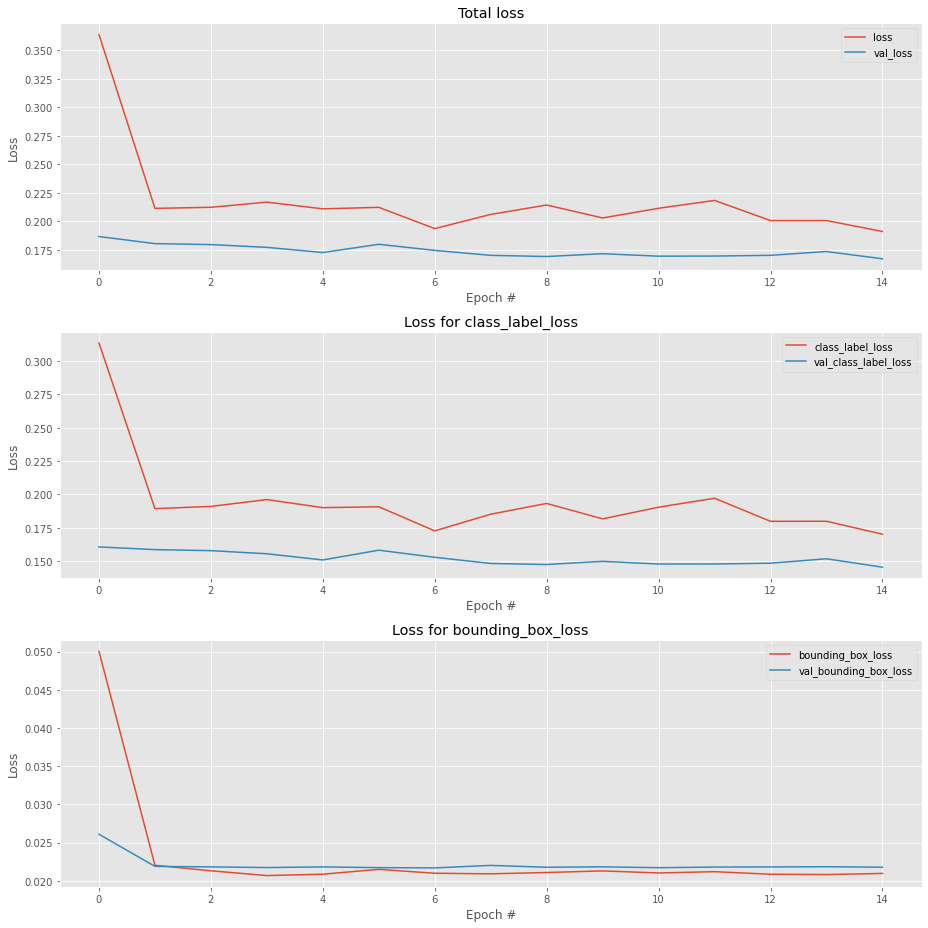

In [16]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 15)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
for (i, l) in enumerate(lossNames):
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
plt.tight_layout()
plotPath = os.path.sep.join([BASE_OUTPUT, "losses.png"])
plt.savefig(plotPath)

Вывод и сохранение графика accuracy:

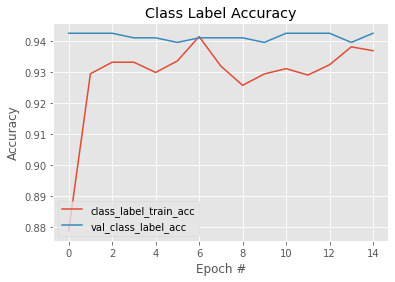

In [17]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plotPath = os.path.sep.join([BASE_OUTPUT, "accs.png"])
plt.savefig(plotPath)